In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


# K-modes
import kmodes

# 나무
from sklearn.tree import export_graphviz
import graphviz

# 데이터 분할
from sklearn.model_selection import train_test_split

# 예측 모형: Logistic regression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC

from sklearn.model_selection import GridSearchCV

# 평가 함수
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score


# https://pypi.org/project/kmodes/
from kmodes.kmodes import KModes

%matplotlib inline
matplotlib.rc('font', family = 'NanumBarunGothic')

path = '/home/pirl/BDAI-정덕성/Group/Python/'
list_files = ['user.csv', 'address.csv', 'contract.csv']

In [164]:
df = pd.read_csv(path + 'merged_final.csv', engine='python', encoding = 'euc-kr')

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49645 entries, 0 to 49644
Data columns (total 23 columns):
gender              49645 non-null object
customerType        49645 non-null object
age                 49645 non-null object
marital             49645 non-null object
residence           49645 non-null object
channel             49645 non-null object
credit              49645 non-null object
payment             49645 non-null object
paymentCO           49645 non-null object
province            49645 non-null object
provinceIS          49645 non-null object
cityGrade           49645 non-null object
channelType         49645 non-null object
contractExtended    49645 non-null object
contractType        49645 non-null object
contractType_1      49645 non-null object
contractType_2      49645 non-null object
cityGradeIS         49645 non-null object
Termination_str     49645 non-null object
maxDay_str          49645 non-null object
maxGift_str         49645 non-null object
Terminati

## X & Y 분리: cityGradeIS 기준

In [166]:
df_tree = df.query('Termination_str == "중도 해약 X"')
df_tree = df_tree.query('customerType == "BUSINESS"')
df_tree['Termination_str'].unique()

array(['중도 해약 X'], dtype=object)

In [168]:
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6037 entries, 8 to 49635
Data columns (total 23 columns):
gender              6037 non-null object
customerType        6037 non-null object
age                 6037 non-null object
marital             6037 non-null object
residence           6037 non-null object
channel             6037 non-null object
credit              6037 non-null object
payment             6037 non-null object
paymentCO           6037 non-null object
province            6037 non-null object
provinceIS          6037 non-null object
cityGrade           6037 non-null object
channelType         6037 non-null object
contractExtended    6037 non-null object
contractType        6037 non-null object
contractType_1      6037 non-null object
contractType_2      6037 non-null object
cityGradeIS         6037 non-null object
Termination_str     6037 non-null object
maxDay_str          6037 non-null object
maxGift_str         6037 non-null object
Termination_rate    6037 non-nu

## 품종 3종

In [194]:
df_tree_short = df_tree.drop(['customerType',
                              'channel', 'channelType',  # channelType 사용
                              'credit', 'payment', 'paymentCO', # 경향성 없음
                              'province', 'provinceIS',
                              'cityGrade', # 실거주지 정보 제외
                              'contractExtended', # 목표변수 파생변수 제외
                              'contractType', 'contractType_2', # 6개 범주 사용
                              'Termination_str', 
                              'maxDay_str', 'maxGift_str', 'Termination_rate', 'overDue_str'],
                             axis=1) # 경향성 없음             
                                  
# X, Y 분리 & Dummy 변수
df_tree_y = df_tree[['contractType_1']]

In [195]:
df_tree_y['contractType_1'].unique()

array(['M', 'E', 'H'], dtype=object)

In [196]:
df_tree_s = pd.get_dummies(df_tree_short.drop('contractType_1', axis=1), drop_first = True)
df_tree_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6037 entries, 8 to 49635
Data columns (total 14 columns):
gender_MALE            6037 non-null uint8
age_30대                6037 non-null uint8
age_40대                6037 non-null uint8
age_50대                6037 non-null uint8
age_60대 이상             6037 non-null uint8
marital_SINGLE         6037 non-null uint8
residence_ETC.         6037 non-null uint8
residence_HOUSE        6037 non-null uint8
residence_OFFICETEL    6037 non-null uint8
cityGradeIS_2급지        6037 non-null uint8
cityGradeIS_3급지        6037 non-null uint8
cityGradeIS_4급지        6037 non-null uint8
cityGradeIS_5급지        6037 non-null uint8
cityGradeIS_6급지        6037 non-null uint8
dtypes: uint8(14)
memory usage: 129.7 KB


In [197]:
# 나무 데이터
df_train_s, df_test_s, df_train_y, df_test_y = train_test_split(df_tree_s, df_tree_y, test_size = 0.3)

print('train data X size:{}'.format(df_train_s.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('test data X size:{}'.format(df_test_s.shape))
print('test data Y size:{}'.format(df_test_y.shape))


train data X size:(4225, 14)
train data Y size:(4225, 1)
test data X size:(1812, 14)
test data Y size:(1812, 1)


# 랜덤포레스트

In [198]:
rf_default = RFC()
rf_default.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [199]:
y_train_pred = rf_default.predict(df_train_s)
y_test_pred = rf_default.predict(df_test_s)

# # AUC
# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, y_pred)
# roc_auc_train = auc(false_positive_rate, true_positive_rate)

# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
# roc_auc_test = auc(false_positive_rate, true_positive_rate)

# f1 score
f1_train = f1_score(df_train_y, y_train_pred, average='micro')
f1_test = f1_score(df_test_y, y_test_pred, average='micro')


# print('Accuracy on Training: {0:.3f}\n'.format(rf_default.score(df_train_s, df_train_y)))
# print('Accuracy on Test: {0:.3f}\n'.format(rf_default.score(df_test_s, df_test_y)))

# # print('AUC on Training: {0:.3f}\n'.format(roc_auc_train))
# # print('AUC on Test: {0:.3f}\n'.format(roc_auc_test))
print('F1 on Training: {0:.3f}\n'.format(f1_train))
print('F1 on Test: {0:.3f}\n'.format(f1_test))

F1 on Training: 0.907

F1 on Test: 0.898



### Parameter

In [200]:
params = {'max_depth': None,
          'n_estimators': None,
          'max_leaf_nodes': None,
          'min_samples_leaf': None,
          'min_samples_split': None,
          'max_features': None}

### 숲의 나무 수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was e

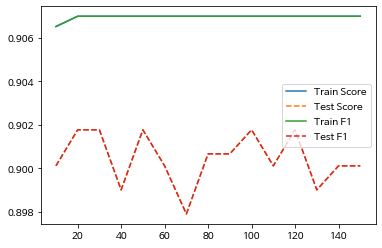

In [201]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# ntree
para_ntree = [10*ntree for ntree in range(1, 16)]


for v_ntree in para_ntree:
    rf = RFC(n_estimators = v_ntree)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_ntree = pd.DataFrame({'N_Tree': para_ntree,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_ntree, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_ntree, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_ntree, train_f1, linestyle='-', label="Train F1")
plt.plot(para_ntree, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [202]:
df_score_ntree.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
1,20,0.906982,0.901766,0.906982,0.901766
2,30,0.906982,0.901766,0.906982,0.901766
4,50,0.906982,0.901766,0.906982,0.901766
9,100,0.906982,0.901766,0.906982,0.901766
11,120,0.906982,0.901766,0.906982,0.901766
7,80,0.906982,0.900662,0.906982,0.900662
8,90,0.906982,0.900662,0.906982,0.900662
0,10,0.906509,0.900110,0.906509,0.900110
5,60,0.906982,0.900110,0.906982,0.900110
10,110,0.906982,0.900110,0.906982,0.900110


In [203]:
params['n_estimators'] = 20

### 나무의 최대 깊이

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


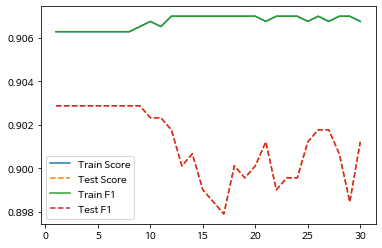

In [206]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# depth
para_depth = [depth for depth in range(1, 31)]


for v_depth in para_depth:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = v_depth)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_depth = pd.DataFrame({'N_Tree': para_depth,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_depth, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_depth, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_depth, train_f1, linestyle='-', label="Train F1")
plt.plot(para_depth, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [207]:
df_score_depth.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
0,1,0.906272,0.902870,0.906272,0.902870
2,3,0.906272,0.902870,0.906272,0.902870
3,4,0.906272,0.902870,0.906272,0.902870
4,5,0.906272,0.902870,0.906272,0.902870
5,6,0.906272,0.902870,0.906272,0.902870
6,7,0.906272,0.902870,0.906272,0.902870
7,8,0.906272,0.902870,0.906272,0.902870
8,9,0.906509,0.902870,0.906509,0.902870
1,2,0.906272,0.902870,0.906272,0.902870
9,10,0.906746,0.902318,0.906746,0.902318


In [208]:
params['max_depth'] = 1

### 최소 잎사귀 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys

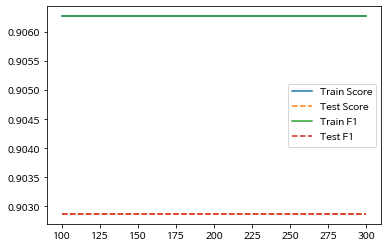

In [212]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# leaf
para_leaf = [leaf*10 for leaf in range(10, 31)]


for v_leaf in para_leaf:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = v_leaf)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_leaf = pd.DataFrame({'Leaf': para_leaf,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_leaf, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_leaf, train_f1, linestyle='-', label="Train F1")
plt.plot(para_leaf, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [211]:
df_score_leaf.sort_values('TestF1', ascending = False)

,Leaf,TrainScore,TestScore,TrainF1,TestF1
0,10,0.906272,0.90287,0.906272,0.90287
1,20,0.906272,0.90287,0.906272,0.90287
2,30,0.906272,0.90287,0.906272,0.90287
3,40,0.906272,0.90287,0.906272,0.90287
4,50,0.906272,0.90287,0.906272,0.90287
5,60,0.906272,0.90287,0.906272,0.90287
6,70,0.906272,0.90287,0.906272,0.90287
7,80,0.906272,0.90287,0.906272,0.90287
8,90,0.906272,0.90287,0.906272,0.90287
9,100,0.906272,0.90287,0.906272,0.90287


In [213]:
params['min_samples_leaf'] = 1

### 최소 분리노드 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pi

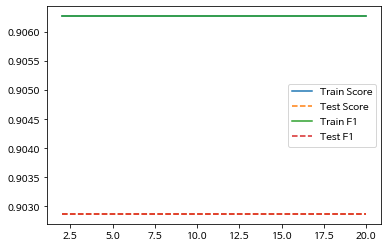

In [214]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# split
para_split = [split*2 for split in range(1, 11)]


for v_split in para_split:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = v_split)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_split = pd.DataFrame({'split': para_split,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_split, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_split, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_split, train_f1, linestyle='-', label="Train F1")
plt.plot(para_split, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [215]:
df_score_split.sort_values('TestF1', ascending = False)

,split,TrainScore,TestScore,TrainF1,TestF1
0,2,0.906272,0.90287,0.906272,0.90287
1,4,0.906272,0.90287,0.906272,0.90287
2,6,0.906272,0.90287,0.906272,0.90287
3,8,0.906272,0.90287,0.906272,0.90287
4,10,0.906272,0.90287,0.906272,0.90287
5,12,0.906272,0.90287,0.906272,0.90287
6,14,0.906272,0.90287,0.906272,0.90287
7,16,0.906272,0.90287,0.906272,0.90287
8,18,0.906272,0.90287,0.906272,0.90287
9,20,0.906272,0.90287,0.906272,0.90287


In [216]:
params['min_samples_split'] = 2

### 최대 사용 변수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

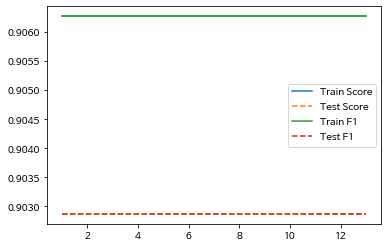

In [217]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# feature
para_feature = [feature for feature in range(1, len(df_train_s.columns))]


for v_feature in para_feature:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = v_feature)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_feature = pd.DataFrame({'feature': para_feature,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_feature, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_feature, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_feature, train_f1, linestyle='-', label="Train F1")
plt.plot(para_feature, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [218]:
df_score_feature.sort_values('TestF1', ascending = False)

,feature,TrainScore,TestScore,TrainF1,TestF1
0,1,0.906272,0.90287,0.906272,0.90287
1,2,0.906272,0.90287,0.906272,0.90287
2,3,0.906272,0.90287,0.906272,0.90287
3,4,0.906272,0.90287,0.906272,0.90287
4,5,0.906272,0.90287,0.906272,0.90287
5,6,0.906272,0.90287,0.906272,0.90287
6,7,0.906272,0.90287,0.906272,0.90287
7,8,0.906272,0.90287,0.906272,0.90287
8,9,0.906272,0.90287,0.906272,0.90287
9,10,0.906272,0.90287,0.906272,0.90287


In [219]:
params['max_features'] = 1

### 최종 모형

In [220]:
rf_final = RFC(n_estimators = params['n_estimators'],
               max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = params['max_features'])
rf_final.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [221]:
y_pred = rf_final.predict(df_test_s)

# f1 score
f1Score = f1_score(df_test_y, y_pred, average = 'micro')

print('F1: {0:.3f}\n'.format(f1Score))
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test_y, y_pred)))
print('Confusion Mat:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

F1: 0.903

Accuracy: 0.903

Confusion Mat:
[[   0    0  134]
 [   0    0   42]
 [   0    0 1636]]


In [222]:
df_importance = pd.DataFrame()
v_feature_name = df_train_s.columns
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_ # TREECLASS.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,residence_HOUSE,0.15
8,residence_OFFICETEL,0.15
11,cityGradeIS_4급지,0.15
0,gender_MALE,0.10
2,age_40대,0.10
3,age_50대,0.10
5,marital_SINGLE,0.10
9,cityGradeIS_2급지,0.05
10,cityGradeIS_3급지,0.05
13,cityGradeIS_6급지,0.05


Text(0, 0.5, '변수')

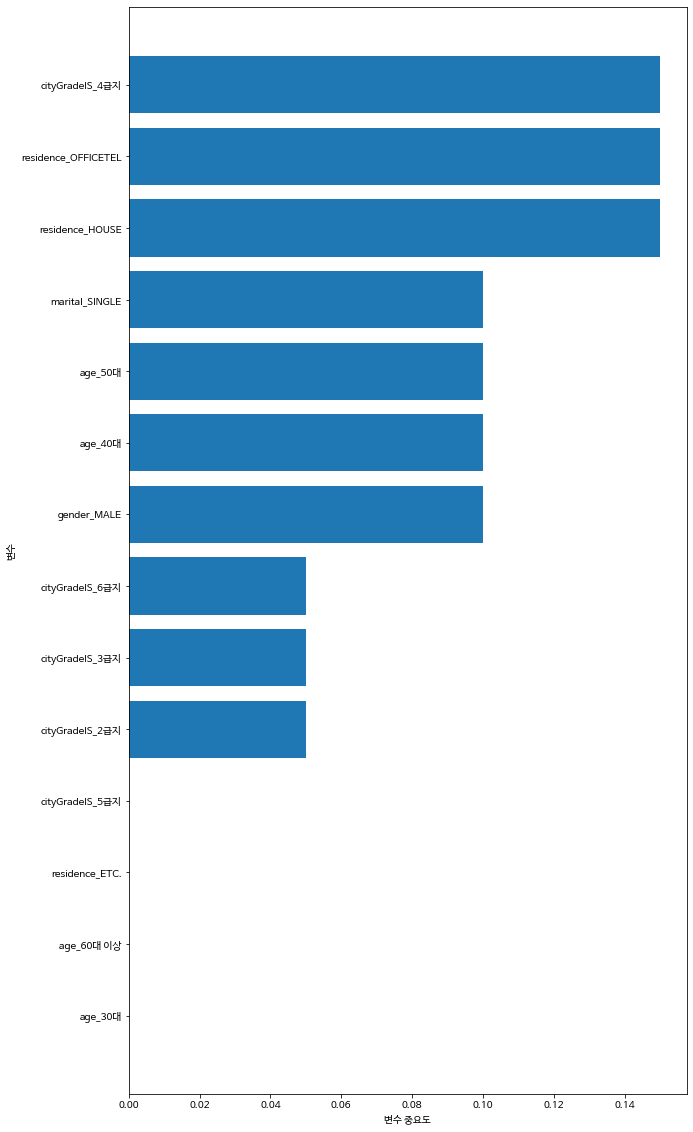

In [223]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(10,20))

plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')